In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

In [12]:
df_spreadspoke = pd.read_csv('spreadspoke_scores.csv')

print(df_spreadspoke.head())

  schedule_date  schedule_season schedule_week  schedule_playoff  \
0      9/2/1966             1966             1             False   
1      9/3/1966             1966             1             False   
2      9/4/1966             1966             1             False   
3      9/9/1966             1966             2             False   
4     9/10/1966             1966             1             False   

            team_home  score_home  score_away        team_away  \
0      Miami Dolphins        14.0        23.0  Oakland Raiders   
1      Houston Oilers        45.0         7.0   Denver Broncos   
2  San Diego Chargers        27.0         7.0    Buffalo Bills   
3      Miami Dolphins        14.0        19.0    New York Jets   
4   Green Bay Packers        24.0         3.0  Baltimore Colts   

  team_favorite_id  spread_favorite over_under_line         stadium  \
0              NaN              NaN             NaN     Orange Bowl   
1              NaN              NaN             NaN 

In [34]:
df_game_data = pd.read_csv('nfl_team_stats_2002-2023.csv')

#print(df_game_data.head())
print(df_game_data.columns)

Index(['season', 'week', 'date', 'time_et', 'neutral', 'away', 'home',
       'score_away', 'score_home', 'first_downs_away', 'first_downs_home',
       'first_downs_from_passing_away', 'first_downs_from_passing_home',
       'first_downs_from_rushing_away', 'first_downs_from_rushing_home',
       'first_downs_from_penalty_away', 'first_downs_from_penalty_home',
       'third_down_comp_away', 'third_down_att_away', 'third_down_comp_home',
       'third_down_att_home', 'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home', 'plays_away',
       'plays_home', 'drives_away', 'drives_home', 'yards_away', 'yards_home',
       'pass_comp_away', 'pass_att_away', 'pass_yards_away', 'pass_comp_home',
       'pass_att_home', 'pass_yards_home', 'sacks_num_away',
       'sacks_yards_away', 'sacks_num_home', 'sacks_yards_home',
       'rush_att_away', 'rush_yards_away', 'rush_att_home', 'rush_yards_home',
       'pen_num_away', 'pen_yards_away', 'pen

In [38]:
# Convert possession time to minutes for both home and away teams
def convert_possession_to_minutes(time_str):
    if pd.isna(time_str):  # Handle any missing values
        return 0
    minutes, seconds = map(int, time_str.split(':'))
    return minutes + seconds / 60  # Convert to total minute

In [39]:
# Apply the conversion to both home and away possession columns
df_game_data['possession_home'] = df_game_data['possession_home'].apply(convert_possession_to_minutes)
df_game_data['possession_away'] = df_game_data['possession_away'].apply(convert_possession_to_minutes)

# Check the results
print(df_game_data[['possession_home']].head())
print(df_game_data[['possession_away']].head())

   possession_home
0        32.466667
1        32.550000
2        34.400000
3        34.400000
4        30.800000
   possession_away
0        27.533333
1        27.450000
2        25.600000
3        25.600000
4        29.200000


In [40]:
# Define home and away columns
home_columns = ['season', 'week', 'date', 'time_et', 'neutral', 'home', 
                'score_home', 'first_downs_home', 'first_downs_from_passing_home',
                'first_downs_from_rushing_home', 'first_downs_from_penalty_home',
                'third_down_comp_home', 'third_down_att_home',
                'fourth_down_comp_home', 'fourth_down_att_home', 'plays_home',
                'drives_home', 'yards_home', 'pass_comp_home', 'pass_att_home',
                'pass_yards_home', 'sacks_num_home', 'sacks_yards_home',
                'rush_att_home', 'rush_yards_home', 'pen_num_home',
                'pen_yards_home', 'redzone_comp_home', 'redzone_att_home',
                'fumbles_home', 'interceptions_home', 'def_st_td_home',
                'possession_home']

away_columns = ['season', 'week', 'date', 'time_et', 'neutral', 'away', 
                'score_away', 'first_downs_away', 'first_downs_from_passing_away',
                'first_downs_from_rushing_away', 'first_downs_from_penalty_away',
                'third_down_comp_away', 'third_down_att_away',
                'fourth_down_comp_away', 'fourth_down_att_away', 'plays_away',
                'drives_away', 'yards_away', 'pass_comp_away', 'pass_att_away',
                'pass_yards_away', 'sacks_num_away', 'sacks_yards_away',
                'rush_att_away', 'rush_yards_away', 'pen_num_away',
                'pen_yards_away', 'redzone_comp_away', 'redzone_att_away',
                'fumbles_away', 'interceptions_away', 'def_st_td_away',
                'possession_away']

# Create separate DataFrames for home and away teams
df_home = df_game_data[home_columns].copy()
df_away = df_game_data[away_columns].copy()

# Display the first few rows of each DataFrame
print("Home Team DataFrame:")
print(df_home.head())

print("\nAway Team DataFrame:")
print(df_away.head())


Home Team DataFrame:
   season week        date  time_et  neutral        home  score_home  \
0    2002    1  2002-09-05  8:30 PM    False      Giants          13   
1    2002    1  2002-09-08  1:00 PM    False     Jaguars          25   
2    2002    1  2002-09-08  1:00 PM    False  Commanders          31   
3    2002    1  2002-09-08  1:00 PM    False    Dolphins          49   
4    2002    1  2002-09-08  1:00 PM    False      Titans          27   

   first_downs_home  first_downs_from_passing_home  \
0                21                             17   
1                19                             11   
2                21                             13   
3                27                             15   
4                22                             15   

   first_downs_from_rushing_home  ...  rush_att_home  rush_yards_home  \
0                              2  ...             22               43   
1                              8  ...             32              118   
2 

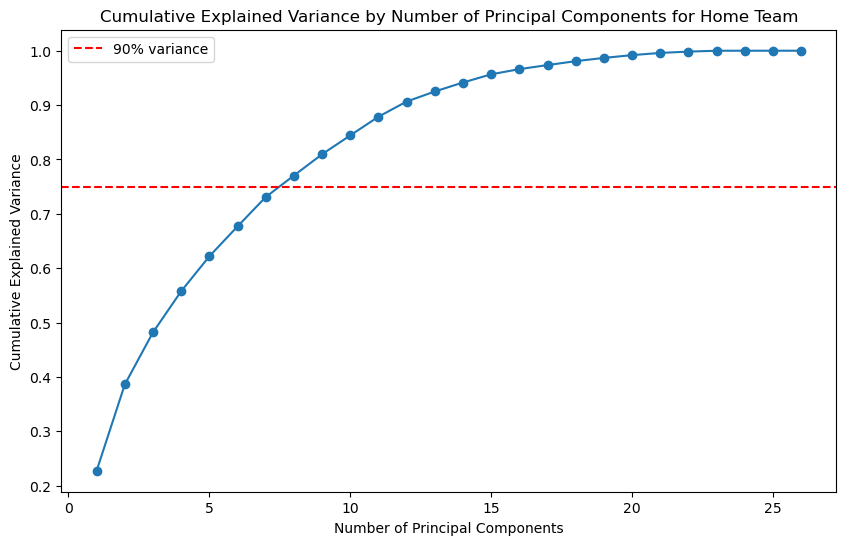

In [45]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and prepare the data (assuming df_home is already created and cleaned)
# Drop non-numeric columns and the target column 'score_home'
features = df_home.drop(columns=['season', 'week', 'date', 'time_et', 'neutral', 'home', 'score_home']).columns.tolist()
X_home = df_home[features].dropna()  # Drop any rows with missing values
y_home = df_home['score_home'].loc[X_home.index]  # Align y_home with X_home

# Standardize the features
scaler = StandardScaler()
X_home_scaled = scaler.fit_transform(X_home)

# Perform PCA
pca = PCA()
X_home_pca = pca.fit_transform(X_home_scaled)

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components for Home Team')
plt.axhline(y=0.75, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.show()


In [42]:
# Get the feature loadings for each principal component
loadings_home = pd.DataFrame(pca.components_, columns=X_home.columns)

# Display the top features for the first few principal components
for i in range(3):  # Modify this to see more components if desired
    print(f"Top features for Principal Component {i+1}:")
    print(loadings_home.iloc[i].abs().sort_values(ascending=False).head(10))
    print("\n")


Top features for Principal Component 1:
first_downs_home                 0.370377
yards_home                       0.348739
plays_home                       0.336807
first_downs_from_passing_home    0.313244
pass_yards_home                  0.298004
possession_home                  0.283705
pass_comp_home                   0.273932
third_down_comp_home             0.239818
pass_att_home                    0.217422
redzone_att_home                 0.180984
Name: 0, dtype: float64


Top features for Principal Component 2:
rush_att_home                    0.407453
rush_yards_home                  0.394813
pass_att_home                    0.371126
first_downs_from_rushing_home    0.365884
pass_comp_home                   0.315791
first_downs_from_passing_home    0.229740
pass_yards_home                  0.215523
sacks_yards_home                 0.190848
sacks_num_home                   0.188866
possession_home                  0.166774
Name: 1, dtype: float64


Top features for Principal C